In [2]:
import eegPinelineDesign
import numpy as np
import random
import mne
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import re
import json
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA,FastICA
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from scipy.fftpack import fft,ifft
import math
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from scipy.signal import spectrogram,find_peaks_cwt,butter, lfilter
from mne.preprocessing.ica import ICA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.cross_validation import train_test_split,ShuffleSplit
from sklearn.preprocessing import label_binarize,scale
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize,StandardScaler
eegPinelineDesign.change_file_directory('C:/Users/ning/Downloads/training set')
EDFfiles, Annotationfiles = eegPinelineDesign.split_type_of_files()

import obspy

In [11]:
file_to_read,fileName=eegPinelineDesign.pick_sample_file(EDFfiles,n=-1)
# channel list for artifact(eyemovement or chewing) removal - ROC and/or LOC
channelList = ['F3','F4','C3','C4','O1','O2','ROC','LOC']
raw = eegPinelineDesign.load_data(file_to_read,channelList,None, 100)# low pass
annotation_to_read = [x for x in Annotationfiles if fileName in x]
file = pd.read_csv(annotation_to_read[0])
labelFind = re.compile('spindle',eegPinelineDesign.re.IGNORECASE)
spindles=[]
for row in file.iterrows():
    currentEvent = row[1][-1]
    if labelFind.search(currentEvent):
        spindles.append(row[1][0])

Extracting edf Parameters from suj9_d2final.edf...
Setting channel info structure...
Creating Raw.info structure...
Reading 0 ... 2589999  =      0.000 ...  2589.999 secs...
Ready.
Fitting ICA to data using 8 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 8
    Searching for artifacts...
    found 1 artifact by EOG 00
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    6, 3, 3, 6
    Removing duplicate indices...
Ready.
Transforming to ICA space (8 components)
Zeroing out 2 ICA components
Low-pass filtering at 5e+02 Hz
Low-pass filtering at 1e+02 Hz


In [12]:
print(spindles)

[284.764, 399.696, 400.446, 489.01, 552.921, 561.161, 571.646, 573.173, 574.068, 621.886, 627.549, 675.549, 704.434, 710.055, 763.35, 780.0735331000001, 829.641, 834.551, 857.08, 918.396, 991.573, 991.573, 992.323, 1035.276, 1051.308, 1051.308, 1060.0, 1063.028, 1063.673, 1080.981, 1106.514, 1106.615, 1115.371, 1127.975, 1337.661, 1341.249, 2389.598]


In [13]:
channelList = ['F3','F4','C3','C4','O1','O2']

In [115]:
def CenterAtPeakOfWindow(timePoint,windowSize,raw,channelIndex):
    tempSegment,timeSpan = eegPinelineDesign.cut_segments(raw,timePoint,channelIndex)
    filter_tempSegment = bandpass(tempSegment[0,:],11,16,1000)
    peakInd = np.array(find_peaks_cwt(filter_tempSegment,np.arange(1,500)))
    max_in_peakInd=np.argmax(abs(filter_tempSegment[peakInd]))
    centerxval=timeSpan[peakInd[max_in_peakInd]]
    return centerxval

399.969 399.969


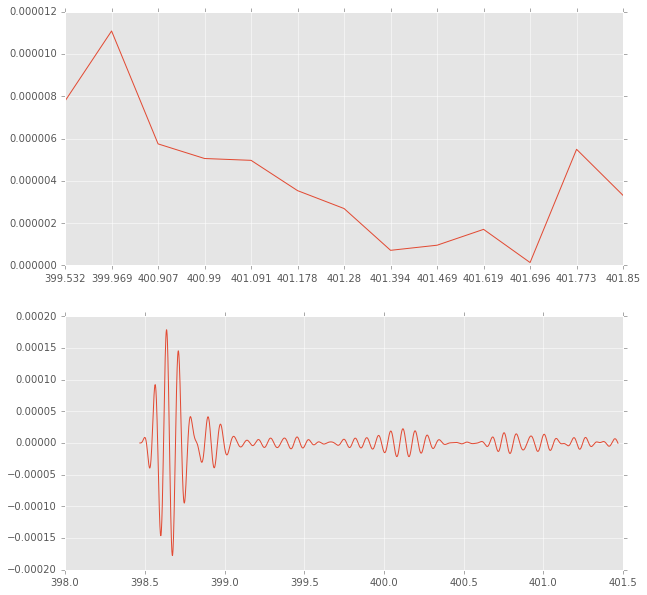

In [116]:
tempSegment, timeSpan = eegPinelineDesign.cut_segments(raw,400.446,0)
filter_Segment = bandpass(tempSegment[0,:],11,16,1000)
peakInd = np.array(find_peaks_cwt(filter_Segment,np.arange(1, 1000)))
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
max_in_peakInd = np.argmax(abs(filter_Segment[peakInd]))
T=timeSpan[peakInd[max_in_peakInd]]
plt.plot(abs(filter_Segment[peakInd]))
plt.xticks(np.arange(len(abs(filter_Segment[peakInd]))),timeSpan[peakInd])
C,TT = eegPinelineDesign.cut_segments(raw,T,0)
C = bandpass(C[0,:],11,16,1000)
print(CenterAtPeakOfWindow(400.446,1.5,raw,0),T)
plt.subplot(2,1,2)
plt.plot(TT,C)

In [117]:
windowSize=1.5
centerXval=np.zeros((len(channelList),len(spindles)))
for ii,spindleTime in enumerate(spindles):
    for channelID, names in enumerate(channelList):
        centerXval[channelID,ii] = CenterAtPeakOfWindow(spindleTime,windowSize,raw,channelID)
        

F3 573.678 True
F4 571.805 True
C3 573.68 True
C4 573.432 True
O1 571.809 True
O2 571.806 True


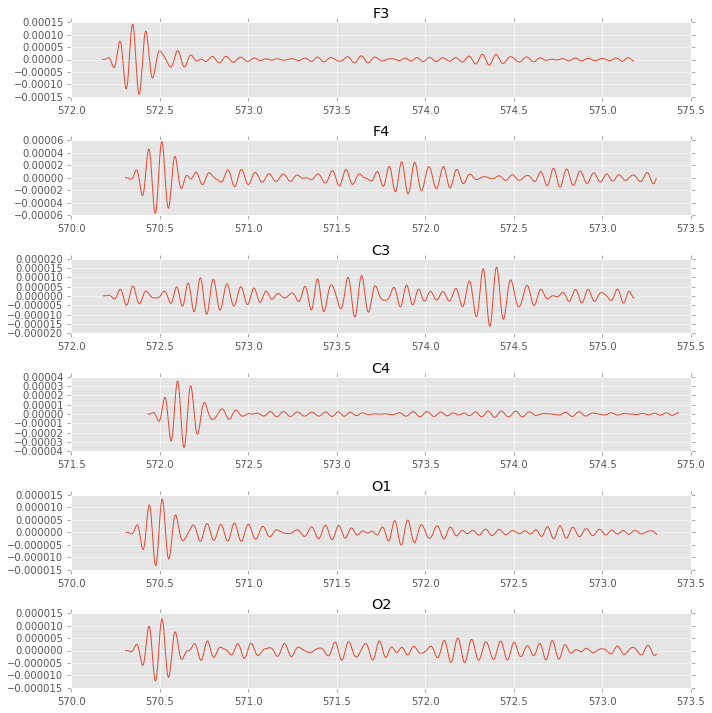

In [124]:

plt.figure(figsize=(10,10))
for ii, value in enumerate(centerXval[:,7]):
    startPoint = value-1.5;endPoint = value+1.5
    start,stop=raw.time_as_index([startPoint,endPoint])
    tempSegment,timeSpan = raw[ii,start:stop]
    plt.subplot(6,1,ii+1)
    Segment = bandpass(tempSegment[0,:],11,16,1000)
    plt.plot(timeSpan,Segment)
    plt.title(channelList[ii])
    print(channelList[ii],value,Threshold_test(value,raw,ii))
plt.tight_layout()

In [75]:
from obspy.signal.filter import bandpass
def Threshold_test(timePoint,raw,channelID,threshold = 0.5,steps=20):
    result = []
    for windowsize in np.linspace(0.1,5,steps):
        startPoint=timePoint-windowsize;endPoint=timePoint+windowsize
        start,stop=raw.time_as_index([startPoint,endPoint])
        tempSegment,timeSpan = raw[channelID,start:stop]
        filter_alpha=bandpass(tempSegment[0,:],8,12,1000)
        RMS_alpha=np.sqrt(sum(filter_alpha**2)/len(filter_alpha))
        
        filter_spindle=bandpass(tempSegment[0,:],11,16,1000)
        RMS_spindle=np.sqrt(sum(filter_spindle**2)/len(filter_spindle))
        
        filter_muscle=bandpass(tempSegment[0,:],30,40,1000)
        RMS_muscle=np.sqrt(sum(filter_muscle**2)/len(filter_muscle))
    
        if (RMS_alpha/RMS_spindle <1.2) and (RMS_muscle < 5*10e-4):
            result.append(1)
        else:
            result.append(0)
    result = np.array(result)
    return sum(result[result==1])/len(result) >=threshold

In [119]:
Result=[]
for timePoint in centerXval[1,:]:
    result = Threshold_test(timePoint,raw,0)
    Result.append(result)
print(Result)

[True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [ ]:
def getOverlap(a,b):
    return max(0,min(a[1],b[1]) - max(a[0],b[0]))
def spindle_overlapping_test(spindles,timePoint,windowsize,tolerance=0.01):
    startPoint=timePoint-windowsize;endPoint=timePoint+windowsize
    return all(getOverlap([startPoint,endPoint],[instance-windowsize,instance+windowsize])<=tolerance for instance in spindles)

In [ ]:
timePoint = 200
spindle_overlapping_test(spindles,timePoint,1.5)

In [ ]:
def used_windows_check(timePoint,used_time_windows,windowsize,tolerance=0.01):
    startPoint=timePoint-windowsize;endPoint=timePoint+windowsize
    return all(getOverlap([startPoint,endPoint],[lower,upper])<=tolerance for (lower,upper) in used_time_windows)

In [ ]:
used_time_windows=[]
used_windows_check(200,used_time_windows,1.5)

In [ ]:
def cut_segments(raw,center,channelIndex,windowsize = 1.5):
    startPoint=center-windowsize;endPoint+windowsize
    start,stop=raw.time_as_index([startPoint,endPoint])
    tempSegment,timeSpan=raw[channelIndex,start:stop]
    return tempSegment,timeSpan

In [ ]:
cut_segments(raw,200,0)

In [ ]:
S,T = raw[0,:]

In [ ]:
np.random.choice(T,1)